# Matched Filter NB For ADMX Gravitational Wave Analysis


First cell outlines all imports

In [37]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pycbc
from pycbc.types import FrequencySeries
from binned4 import run_binned4
from psd_computation import compute_stacked_psd_welch_from_h5
from matched_filter_core import matched_filter_on_common_grid, normalize_template_fd
from pycbc.waveform import get_fd_waveform
from scipy.interpolate import PchipInterpolator

# Run binning script for ADMX High Resolution Data  
Below code takes their high resolution data and downsamples it sokmewhere between their high resolution data and medium resolution data.  
Gravitational Wave analysis requires high resolution for binary merger events, but too high sampling makes computation time intensive  
After binning we compute the reciever shape imposed by the band pass filters and divide this out  
After this we have the frequency domain raw voltage (complex)  
We need the voltage for matched filtering as this maintains all phase information, which is essential for matched filtering  
So the template then needs to be constructed to match the voltage output from the receiver chain.

In [3]:
outputs, receiver_h5, f_baseband, G_baseband = run_binned4(
    run_definition_path="run1b_definitions.yaml",
    nibble_name="nibble5",
    num_bins=2**21,
    crop_seconds=2.0,
    receiver_poly_deg=3,
    HR_folder="hr_data",
    data_folder="2018_05_19",
    output_subfolder="binned_hr_data",
    do_binning=False
)

outputs[:5]




do_binning = False
num_bins   = (unused; using native rFFT grid)
Building receiver templates (POWER→sqrt) with separate Re/Im dividers ...
Saved receiver template: hr_data/run1b_nibble5_receiver_shape_hr_voltage.h5
Loaded receiver dividers
Done. All matched files processed.


['hr_data/binned_hr_data/admx_data_2018_05_19_23_00_33_channel_1_binned.h5',
 'hr_data/binned_hr_data/admx_data_2018_05_19_23_03_35_channel_1_binned.h5',
 'hr_data/binned_hr_data/admx_data_2018_05_19_23_05_46_channel_1_binned.h5',
 'hr_data/binned_hr_data/admx_data_2018_05_19_23_07_51_channel_1_binned.h5',
 'hr_data/binned_hr_data/admx_data_2018_05_19_23_10_53_channel_1_binned.h5']

# Illustrating binned data and format

Using example binned file:
  ./hr_data/binned_hr_data/admx_data_2018_05_19_23_00_33_channel_1_binned.h5
File attrs keys: ['N_time', 'bin_factor', 'delta_f_binned', 'delta_t', 'fstart_abs_hz', 'fstop_abs_hz', 'notes', 'num_bins']
run_params keys: ['Attenuation', 'Cavity_Resonant_Frequency', 'Digitizer_Log_ID', 'Filename_Tag', 'Integration_Time', 'JPA_SNR', 'Quality_Factor', 'Reflection', 'Start_Frequency', 'Stop_Frequency', 'Thfet', 'Transmission']
Delta_f_binned: 0.010437608684731712  Hz

Shapes:
  f_baseband: (4678096,)    f_abs: (4678096,)
  X_raw: (4678096,)    X_flat: (4678096,)
  G_used: (4678096,)


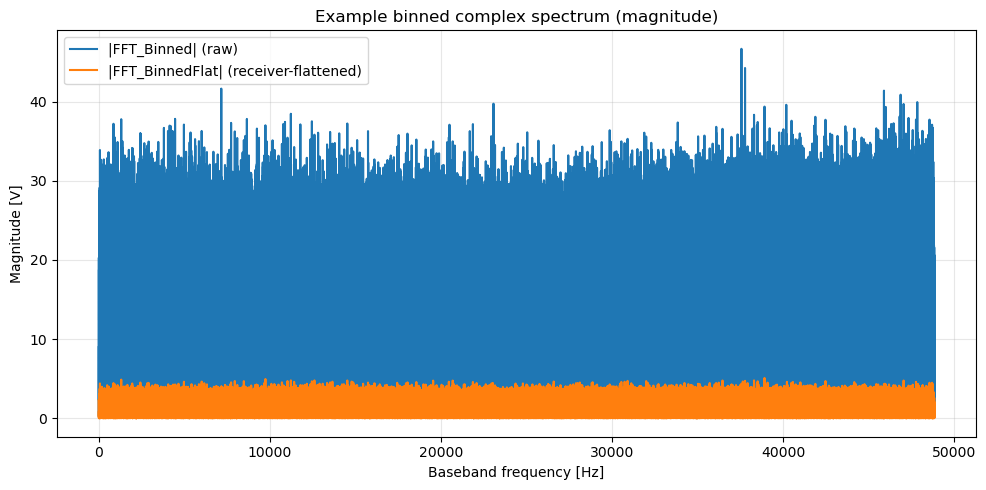

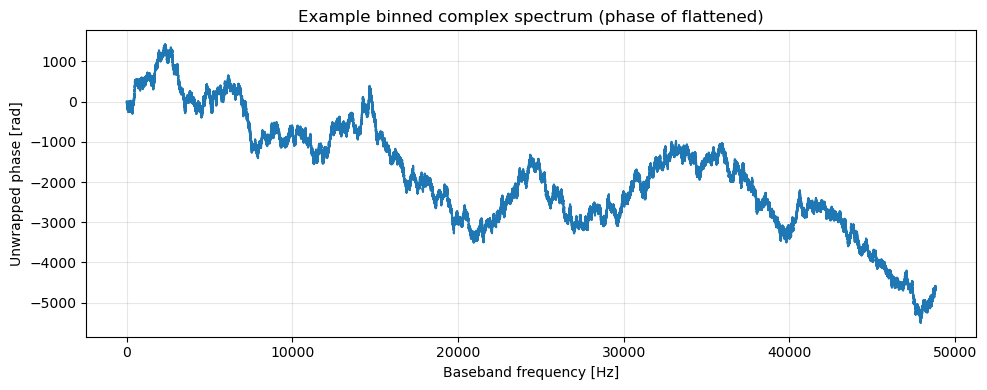

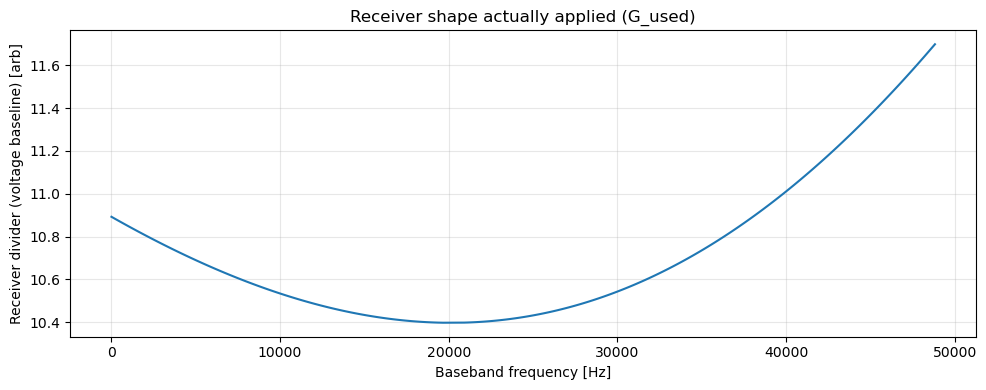

Quality_Factor: 39670.8725991
Cavity_Resonant_Frequency: 740.004609589
Start_Frequency: 739.980191761
Stop_Frequency: 740.029019886
Filename_Tag: _data_2018_05_19_23_00_33_channel_1.dat


In [11]:
# ----------------------------
binned_dir = "./hr_data/binned_hr_data"

# grab the first match (or change the pattern)
cands = sorted(glob.glob(os.path.join(binned_dir, "*_binned.h5")))
if len(cands) == 0:
    raise FileNotFoundError(f"No *_binned.h5 files found in {binned_dir}")

binned_h5 = cands[0]
print("Using example binned file:\n ", binned_h5)

# ----------------------------
# 2) load the stored frequency grids + complex spectra
# ----------------------------
with h5py.File(binned_h5, "r") as f:
    f_baseband = f["f_baseband"][:]   # Hz
    f_abs = f["f_abs"][:]             # Hz

    # raw binned complex FFT
    X_raw = f["FFT_Binned_Re"][:] + 1j * f["FFT_Binned_Im"][:]

    # receiver-flattened binned complex FFT (preferred for MF)
    X_flat = f["FFT_BinnedFlat_Re"][:] + 1j * f["FFT_BinnedFlat_Im"][:]

    # receiver divider actually applied (voltage baseline)
    G_used = f["Receiver Shape"][:] if "Receiver Shape" in f else None

    # metadata
    meta = dict(f.attrs)



    # run_params saved as group attrs (your latest format)
    run_params = {}
    if "run_params" in f:
        for k, v in f["run_params"].attrs.items():
            if isinstance(v, (bytes, np.bytes_)):
                run_params[k] = v.decode("utf-8")
            elif isinstance(v, np.generic):
                run_params[k] = v.item()
            else:
                run_params[k] = v

print("File attrs keys:", list(meta.keys()))
print("run_params keys:", list(run_params.keys()))
key = list(meta.keys())[2]
delta_f_binned = meta[key]
print("Delta_f_binned:", delta_f_binned, " Hz")

# ----------------------------
# 3) quick sanity checks
# ----------------------------
print("\nShapes:")
print("  f_baseband:", f_baseband.shape, "   f_abs:", f_abs.shape)
print("  X_raw:", X_raw.shape, "   X_flat:", X_flat.shape)
if G_used is not None:
    print("  G_used:", np.asarray(G_used).shape)

# ----------------------------
# 4) plot example: magnitude/phase on baseband axis
# ----------------------------
# skip DC for log plots
s = slice(1, None)

plt.figure(figsize=(10, 5))
plt.plot(f_baseband[s], np.abs(X_raw[s]), label="|FFT_Binned| (raw)")
plt.plot(f_baseband[s], np.abs(X_flat[s]), label="|FFT_BinnedFlat| (receiver-flattened)")
plt.xlabel("Baseband frequency [Hz]")
plt.ylabel("Magnitude [V]")
plt.title("Example binned complex spectrum (magnitude)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(f_baseband[s], np.unwrap(np.angle(X_flat[s])))
plt.xlabel("Baseband frequency [Hz]")
plt.ylabel("Unwrapped phase [rad]")
plt.title("Example binned complex spectrum (phase of flattened)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 5) optional: overlay receiver divider (if present)
# ----------------------------
if G_used is not None:
    plt.figure(figsize=(10, 4))
    plt.plot(f_baseband[s], G_used[s])
    plt.xlabel("Baseband frequency [Hz]")
    plt.ylabel("Receiver divider (voltage baseline) [arb]")
    plt.title("Receiver shape actually applied (G_used)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ----------------------------
# 6) print a couple run params you care about
# ----------------------------
if run_params:
    for k in ["Quality_Factor", "Cavity_Resonant_Frequency", "Start_Frequency", "Stop_Frequency", "Filename_Tag"]:
        if k in run_params:
            print(f"{k}: {run_params[k]}")

$ V = V_R +iV_C$ \

$ p = V_r^2 +V_C^2$

# Illustrate the Normalized High Resoultion data

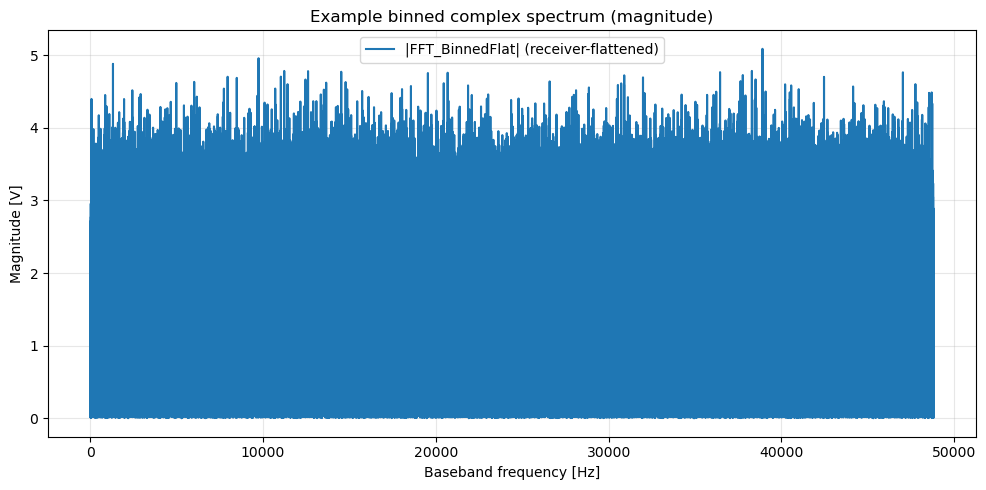

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(f_baseband[s], np.abs(X_flat[s]), label="|FFT_BinnedFlat| (receiver-flattened)")
plt.xlabel("Baseband frequency [Hz]")
plt.ylabel("Magnitude [V]")
plt.title("Example binned complex spectrum (magnitude)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Computing the Power Spectral Density  
Power spectral density is done by averaging over all datasets and is outlined in psd_computation.py


PSD stats:
  min   = 1.8636382833170593e-12
  median= 3.2768014190044697e-12
  max   = 5.084914172611069e-12
Used files: 25 Skipped: 0
10 smallest PSD values: [1.86363828e-12 1.86488634e-12 1.86615995e-12 1.86708276e-12
 1.86868162e-12 1.86927918e-12 1.87120329e-12 1.87147560e-12
 1.87367202e-12 1.87372496e-12]
Used: 25 Skipped: 0


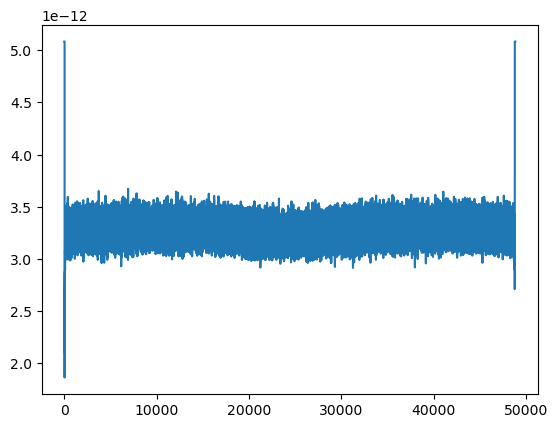

In [13]:
psd_fd, freqs, used_files, skipped = compute_stacked_psd_welch_from_h5(
    binned_dir="./hr_data/binned_hr_data",
    prefer_flat=True,       # use the same version you matched filter against
    seg_len_sec=1.0,        # adjust if you want
    seg_stride_sec=0.5,
    avg_method="median",
    stack_method="median",
    psd_floor=None,         # leave None first
    f_low=20.0,             # match your f_low in matched filtering
    f_high=48.77e3,
    verbose=True,
)
print("Used:", len(used_files), "Skipped:", len(skipped))
psd_fd[-10:] = np.median(psd_fd[-200:-10])
plt.plot(freqs,psd_fd)

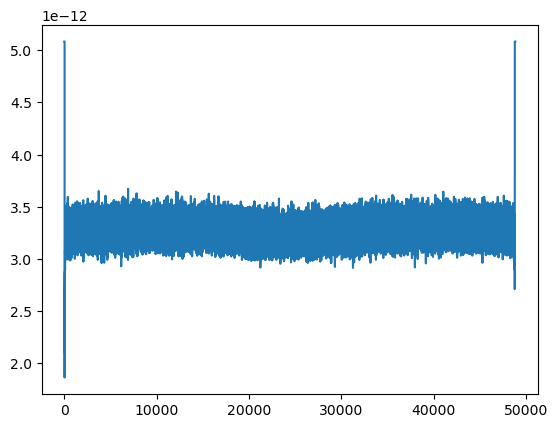

In [14]:
plt.plot(freqs,psd_fd)

In [15]:
psd_arr = np.asarray(psd_fd.numpy(), dtype=np.float64)
bad = (~np.isfinite(psd_arr)) | (psd_arr <= 0)
print("PSD bad bins:", bad.sum(), "of", len(psd_arr))

# look at the actual minimum positive value in-band
pos = psd_arr[(psd_arr > 0) & np.isfinite(psd_arr)]
print("PSD min positive:", pos.min(), "median:", np.median(pos))

# hard floor at, say, 1e-10 * median (pick something non-insane)
floor = np.median(pos) * 1e-4
psd_safe = np.maximum(psd_arr, floor)
psd_safe[0] = psd_safe[0] if psd_safe[0] > 0 else floor

psd_safe = FrequencySeries(psd_safe, delta_f=psd_fd.delta_f)

PSD bad bins: 0 of 4678096
PSD min positive: 1.8636382833170593e-12 median: 3.2768014190044697e-12


# Creating Voltage Template from Specific Run Parameters

9.184206521498887e-20


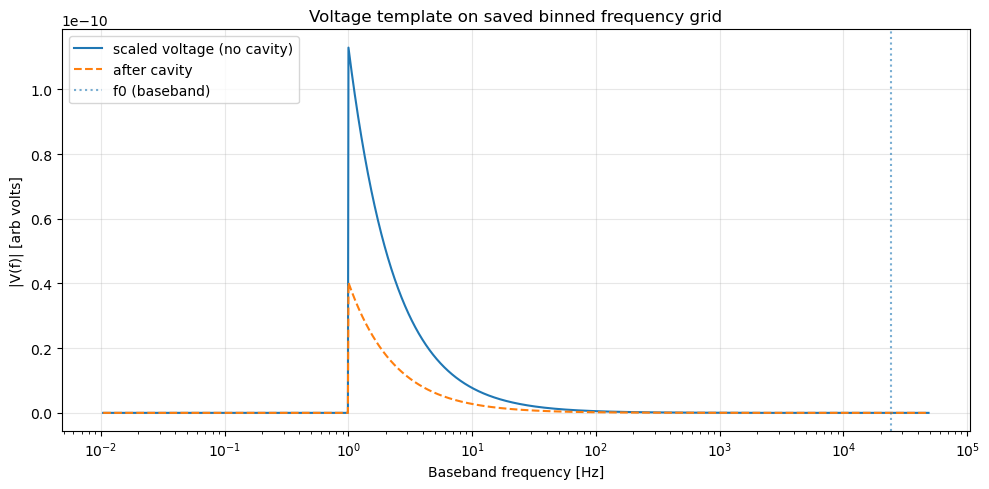

In [16]:
from create_waveform_template import build_voltage_template_on_binned_grid, plot_voltage_template

out = build_voltage_template_on_binned_grid(
    binned_h5="./hr_data/binned_hr_data/admx_data_2018_05_19_23_20_24_channel_1_binned.h5",
    run_definition_path="./run1b_definitions.yaml",
    target_nibble="nibble5",
    approximant="TaylorF2",
    mass1=1.4,
    mass2=1.4,
    apply_cavity=True,
)
voltage_template = np.multiply(0.1,out["V_fd_final"])
strain_hp = out["hp_native"]
print(max(np.abs(strain_hp)))
plot_voltage_template(out)


# Now run Matched filter using ADMX voltage data, expected binary template and PSD

<class 'tuple'>
[<class 'pycbc.types.timeseries.TimeSeries'>, <class 'pycbc.types.frequencyseries.FrequencySeries'>, <class 'numpy.float64'>]
Peak SNR = 7.29754860512403 at t = 27.381729280000005 sec


/Users/chrisewasiuk/miniconda3/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/chrisewasiuk/miniconda3/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


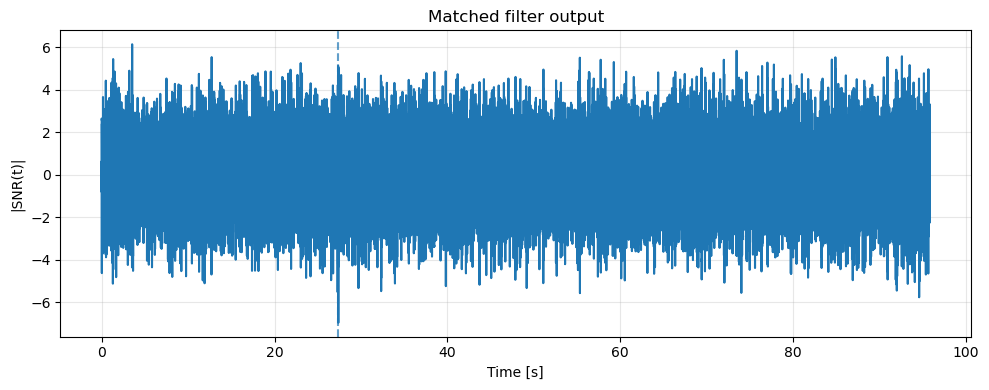

/var/folders/__/68q69_j51cj16zb24xlwg1kw0000gn/T/ipykernel_19827/3195250580.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/chrisewasiuk/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


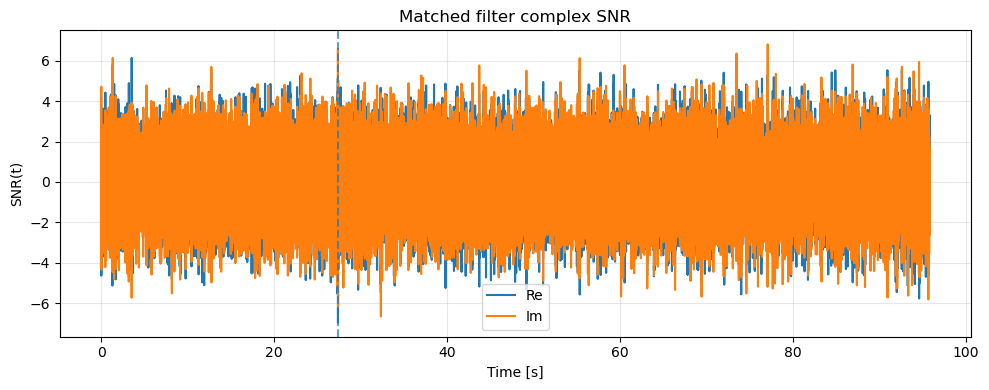

In [17]:

X_flat = FrequencySeries(np.asarray(X_flat, dtype=np.complex128), delta_f=delta_f_binned)
voltage_template = FrequencySeries(np.asarray(voltage_template, dtype=np.complex128), delta_f=delta_f_binned)
psd_final = FrequencySeries(np.asarray(psd_fd, dtype=np.float64), delta_f=delta_f_binned)
bin_factor = int(meta["bin_factor"])  # from your binned h5 attrs



snr_ts, peak = matched_filter_on_common_grid(
    data_fd=X_flat,
    template_fd=voltage_template,
    psd_fd=psd_final,
    f_low=20,    
    f_high=48.77e3,    
)

print("Peak SNR =", peak["snr_peak"], "at t =", peak["t_peak_sec"], "sec")

# ---- plot |SNR(t)| and mark peak
t = np.arange(len(snr_ts)) * float(snr_ts.delta_t)
snr_abs = np.abs(snr_ts.numpy())

plt.figure(figsize=(10, 4))
plt.plot(t, snr_ts)
plt.axvline(peak["t_peak_sec"], linestyle="--", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("|SNR(t)|")
plt.title("Matched filter output")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- optional: plot real/imag too
plt.figure(figsize=(10, 4))
plt.plot(t, np.real(snr_ts.numpy()), label="Re")
plt.plot(t, np.imag(snr_ts.numpy()), label="Im")
plt.axvline(peak["t_peak_sec"], linestyle="--", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("SNR(t)")
plt.title("Matched filter complex SNR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Inject Synthetic Signal

In [18]:
import numpy as np
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.psd import interpolate
from pycbc.noise.gaussian import noise_from_psd
from pycbc.filter import matched_filter_core, sigma

def infer_time_params_from_fd(fd: FrequencySeries):
    n_freq = len(fd)                  # rFFT bins
    n_time = 2 * (n_freq - 1)         # implied time samples
    df = float(fd.delta_f)
    duration = 1.0 / df               # seconds
    dt = duration / n_time
    return n_time, dt, duration

def ensure_psd_on_grid(psd_fd: FrequencySeries, df: float, n_freq: int, psd_floor=1e-60):
    if psd_fd.delta_f != df or len(psd_fd) != n_freq:
        psd_fd = interpolate(psd_fd, df, n_freq)

    arr = np.asarray(psd_fd.numpy(), dtype=np.float64)
    arr = np.where(np.isfinite(arr), arr, psd_floor)
    arr = np.maximum(arr, psd_floor)
    arr[0] = max(arr[0], psd_floor)
    return FrequencySeries(arr, delta_f=df)

In [19]:
def make_injected_data(
    template_fd: FrequencySeries,
    psd_fd: FrequencySeries,
    target_snr=10.0,
    t_inject=10.0,
    f_low=None,
    f_high=None,
    seed=1234,
    psd_floor=1e-60,
):
    if not isinstance(template_fd, FrequencySeries):
        raise TypeError("template_fd must be a FrequencySeries")
    if not isinstance(psd_fd, FrequencySeries):
        raise TypeError("psd_fd must be a FrequencySeries")

    df = float(template_fd.delta_f)
    n_time, dt, duration = infer_time_params_from_fd(template_fd)

    psd_on = ensure_psd_on_grid(psd_fd, df=df, n_freq=len(template_fd), psd_floor=psd_floor)

    noise_ts = noise_from_psd(length=n_time, delta_t=dt, psd=psd_on, seed=seed)

    template_ts = template_fd.to_timeseries()

    if len(template_ts) != n_time:
        template_ts = TimeSeries(template_ts.numpy()[:n_time], delta_t=dt)

    template_ts = template_ts.cyclic_time_shift(-template_ts.start_time)

    sig = float(sigma(template_fd, psd_on, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high))

    if not np.isfinite(sig) or sig <= 0:
        raise ValueError(f"sigma(template) is invalid: {sig}. Check PSD and frequency cuts.")

    scale = float(target_snr) / sig
    template_ts_scaled = TimeSeries(scale * template_ts.numpy(), delta_t=dt)

    i0 = int(np.round(t_inject / dt)) % n_time
    injected = noise_ts.copy()
    injected_np = injected.numpy()
    temp_np = template_ts_scaled.numpy()

    injected_np = np.roll(injected_np, i0) + temp_np
    injected_np = np.roll(injected_np, -i0)

    injected = TimeSeries(injected_np, delta_t=dt)

    return injected, noise_ts, template_ts_scaled, psd_on, {"dt": dt, "duration": duration, "sigma": sig, "scale": scale}

In [20]:
def matched_filter_fd(data_ts: TimeSeries, template_fd: FrequencySeries, psd_fd: FrequencySeries,
                      f_low=None, f_high=None, psd_floor=1e-60):

    data_fd = data_ts.to_frequencyseries()

    df = float(template_fd.delta_f)
    if float(data_fd.delta_f) != df or len(data_fd) != len(template_fd):
        raise ValueError("data_fd and template_fd are not on the same frequency grid")

    psd_on = ensure_psd_on_grid(psd_fd, df=df, n_freq=len(template_fd), psd_floor=psd_floor)

    out = matched_filter_core(
        template_fd,
        data_fd,
        psd=psd_on,
        low_frequency_cutoff=f_low,
        high_frequency_cutoff=f_high,
    )

    if isinstance(out, tuple):
        snr_fd = out[0]
    else:
        snr_fd = out

    snr_ts = snr_fd.to_timeseries()
    snr_abs = np.abs(snr_ts.numpy())
    i_peak = int(np.argmax(snr_abs))

    peak = {
        "snr_peak": float(snr_abs[i_peak]),
        "snr_peak_complex": complex(snr_ts[i_peak]),
        "t_peak_sec": float(i_peak * snr_ts.delta_t),
        "delta_t": float(snr_ts.delta_t),
        "delta_f": df,
    }
    return snr_ts, peak

Requested injection SNR: 10.0
Computed template sigma: 3.140611819183097e-06
Applied scale factor: 3184092.9652366573
Recovered peak SNR: 0.0007261873195425921
Recovered peak time [s]: 19.997173760000003


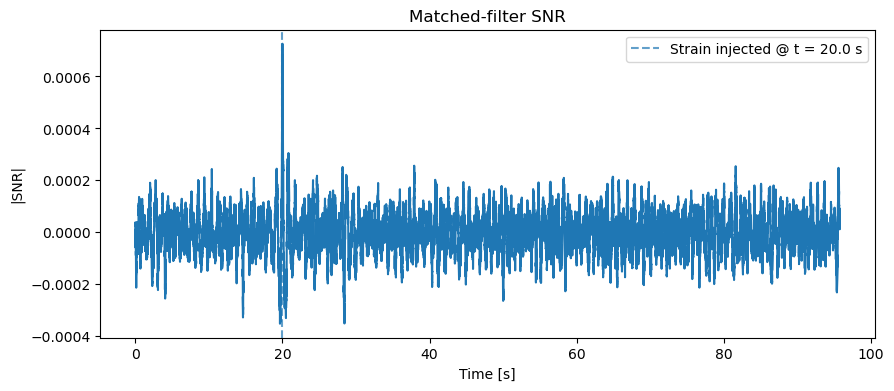

In [21]:
# You provide these:
# template_fd : FrequencySeries (complex), on the same grid you want to use
# psd_fd      : FrequencySeries (real, V^2/Hz), on same grid or interpolatable

f_low = None      # set if you want, example 1e3
f_high = None     # set if you want
target_snr = 10.0
t_inject = -20.0 # negative sign convention to avoid filter wraparound 
seed = 1234

data_ts, noise_ts, template_ts_scaled, psd_on, info = make_injected_data(
    template_fd=voltage_template,
    psd_fd=psd_fd,
    target_snr=target_snr,
    t_inject=t_inject,
    f_low=f_low,
    f_high=f_high,
    seed=seed,
)

snr_ts, peak = matched_filter_fd(
    data_ts=data_ts,
    template_fd=voltage_template,
    psd_fd=psd_on,
    f_low=f_low,
    f_high=f_high,
)

print("Requested injection SNR:", target_snr)
print("Computed template sigma:", info["sigma"])
print("Applied scale factor:", info["scale"])
print("Recovered peak SNR:", peak["snr_peak"])
print("Recovered peak time [s]:", peak["t_peak_sec"])
plt.figure(figsize=(10, 4))
plt.plot(t,snr_ts)
plt.axvline(np.abs(t_inject), linestyle="--", alpha=0.7, label = f"Strain injected @ t = {np.abs(t_inject)} s")
plt.xlabel("Time [s]")
plt.ylabel("|SNR|")
plt.title("Matched-filter SNR")
plt.legend()



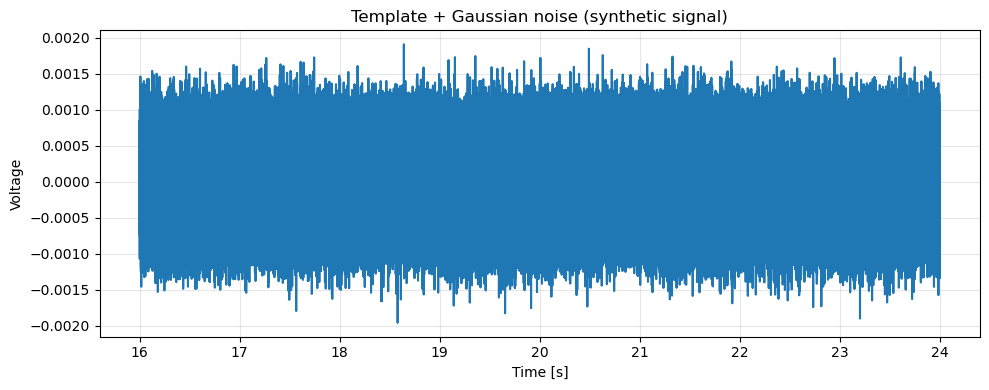

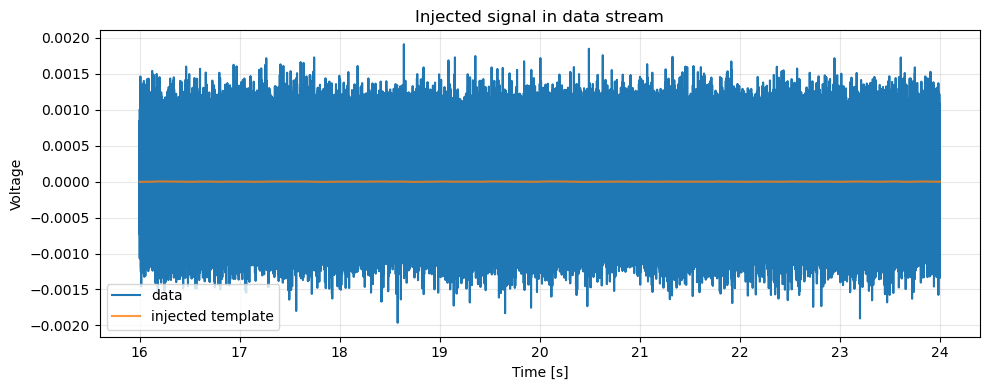

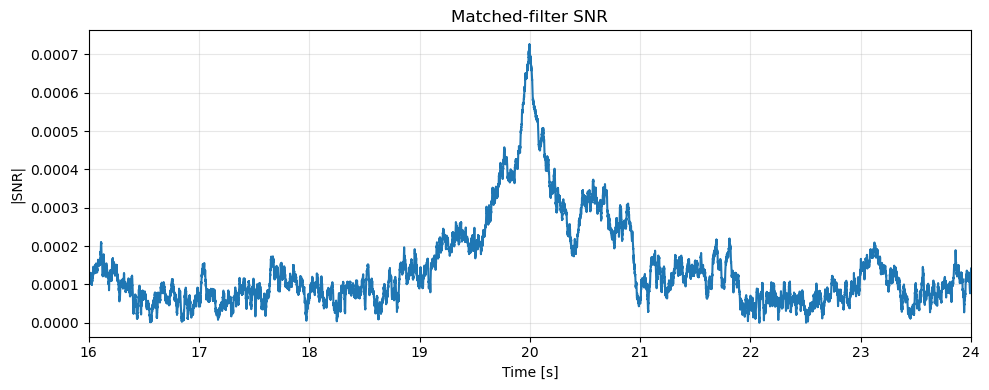

In [22]:
import numpy as np
import matplotlib.pyplot as plt

dt = float(data_ts.delta_t)
n  = len(data_ts)
t  = np.arange(n) * dt

# Zoom window
t0 = np.abs(t_inject)
win = 4 # seconds on either side
mask = (t >= (t0 - win)) & (t <= (t0 + win))

# Build injected template at the correct time
inj = template_ts_scaled.copy()
inj_np = np.roll(inj.numpy(), int(np.round(t_inject / dt)) % n)
inj = type(inj)(inj_np, delta_t=dt)

# ------------------------------------------------------------
# 1) Template + Gaussian noise (synthetic realization)
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(t[mask], (noise_ts.numpy() + inj.numpy())[mask])
plt.xlabel("Time [s]")
plt.ylabel("Voltage")
plt.title("Template + Gaussian noise (synthetic signal)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2) Full data stream (noise + injected signal)
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(t[mask], data_ts.numpy()[mask], label="data")
plt.plot(t[mask], inj.numpy()[mask], label="injected template", alpha=0.8)
plt.xlabel("Time [s]")
plt.ylabel("Voltage")
plt.title("Injected signal in data stream")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) Matched-filter SNR
# ------------------------------------------------------------
snr_t = np.arange(len(snr_ts)) * float(snr_ts.delta_t)
snr_abs = np.abs(snr_ts.numpy())
mask_snr = (snr_t >= (t0 - win)) & (snr_t <= (t0 + win))

plt.figure(figsize=(10, 4))
plt.plot(snr_t[mask_snr], snr_abs[mask_snr])
plt.axvline(t_inject, linestyle="--", alpha=0.7)
plt.xlim(16,24)
plt.xlabel("Time [s]")
plt.ylabel("|SNR|")
plt.title("Matched-filter SNR")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estimating the minimum detectable template voltage 

In [28]:
# Code here to return minimum threshold for template voltage
# need to determine statistically what qualifies as a detected signal

/var/folders/__/68q69_j51cj16zb24xlwg1kw0000gn/T/ipykernel_19827/3380204004.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rho_noise = np.array(X_flat)


NameError: name 'rho_obs' is not defined

# From minimum voltage estimate minimum strain

Relevant Voltage Equation is : 

$$ V = \sqrt{\frac{1}{2 \mu c^2} Q \omega_g^3 V_{cav}^{5/3}} \eta h_0 B_0 $$ 

Solving for strain is :
$$ h_0 = V \sqrt{\frac{2 \mu c^2}{ Q \omega_g^3 V_{cav}^{5/3}} } \frac{1}{\eta B_0} $$


In [31]:
V_min = 1e-12 # Placeholder

mu0 = 4 * np.pi * 1e-7      # vacuum permeability [N/A^2 = kg m / (A^2 s^2)]
c = 299_792_458.0           # speed of light [m/s]
V_liters =136.0*  1e-3   # liters -> m^3
eta = 0.1 # Replace when analysis is finished
Q_fact = out["Q"]
B_field = out["B"]
freq_axis = out["f_abs_hz"]

# get full strain as a funct of freq ( an array )
h_min = V_min/(eta*B_field)*np.sqrt(2 * mu0 *c**2/(Q_fact*freq_axis**3 *V_liters**(5/3) ))
print("Minimum strain detectable: ", max(h_min))

Minimum strain detectable:  8.13369038492688e-22


scores_1mpc min/max: 2.70199296871339e-08 0.12541540392080316
fraction detectable: 0.39145833333333335


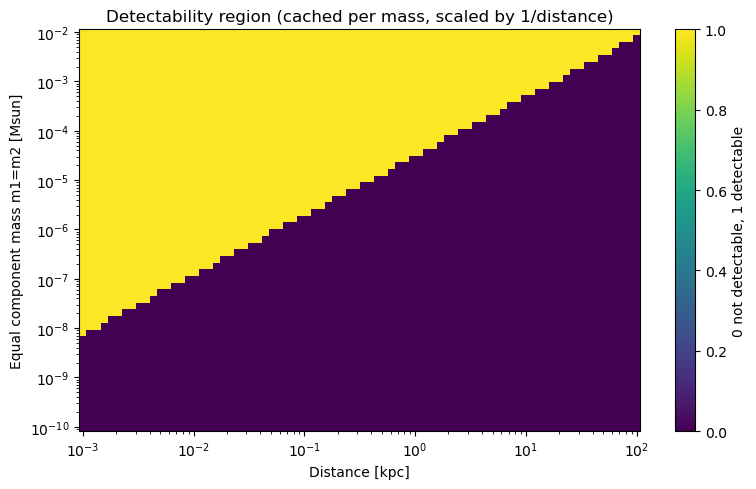

In [39]:

# You already have these from your earlier steps
f_baseband = out["f_baseband_hz"].astype(np.float64)
f_abs = out["f_abs_hz"].astype(np.float64)
df_target = float(out["df_target"])

# Your h_min(f) array on the same bins
# (use your existing h_min computation; here I assume h_min already exists)
h_min = np.asarray(h_min, dtype=np.float64)
h_min = np.where(np.isfinite(h_min) & (h_min > 0), h_min, np.inf)

# Choose grids
masses = np.logspace(-10, -2, 60)         # Msun
distances_kpc = np.logspace(-3, 2, 80)    # kpc
distances_mpc = distances_kpc / 1000.0

# Controls to avoid huge allocations
approximant = "TaylorF2"
df_floor = 10.0                           # Hz, try 10, 50, 100 if needed
f_lower = max(1.0, float(f_baseband[1]))
f_final = float(f_baseband[-1])           # only generate what you need in band
ref_distance_mpc = 1.0                    # reference distance for caching

# Helper: compute waveform on coarse df_use and interpolate to f_baseband once
def waveform_on_baseband_for_mass(m_solar):
    df_use = max(df_target, df_floor)
    hp, hc = get_fd_waveform(
        approximant=approximant,
        mass1=float(m_solar),
        mass2=float(m_solar),
        delta_f=float(df_use),
        f_lower=float(f_lower),
        f_final=float(f_final),
        distance=float(ref_distance_mpc)
    )
    f_hp = np.arange(len(hp), dtype=np.float64) * float(hp.delta_f)
    H_bb = interp_complex_amp_phase(hp, f_hp, f_baseband, amp_floor=0.0, fill_value=0.0)
    return np.abs(H_bb)

# Precompute per-mass ratio curve at 1 Mpc
# ratio_1mpc(f) = |H_1mpc(f)| / h_min(f)
# score_1mpc = max_f ratio_1mpc(f)
scores_1mpc = np.empty(len(masses), dtype=np.float64)

for i, m in enumerate(masses):
    H_abs_1mpc = waveform_on_baseband_for_mass(m)
    ratio_1mpc = H_abs_1mpc / h_min
    ratio_1mpc = np.where(np.isfinite(ratio_1mpc), ratio_1mpc, 0.0)
    scores_1mpc[i] = float(np.max(ratio_1mpc))

print("scores_1mpc min/max:", scores_1mpc.min(), scores_1mpc.max())

# Now fill detectability map cheaply using distance scaling
# score(m, d) = score_1mpc(m) * (ref_distance_mpc / d_mpc)
# Detectable if score >= 1
target = 1.0

detect_map = np.zeros((len(masses), len(distances_mpc)), dtype=bool)
score_map = np.zeros_like(detect_map, dtype=np.float64)

for i, sc in enumerate(scores_1mpc):
    # vectorized over distances
    sc_d = sc * (ref_distance_mpc / distances_mpc)
    score_map[i, :] = sc_d
    detect_map[i, :] = (sc_d >= target)

print("fraction detectable:", detect_map.mean())

# Two-color plot
plt.figure(figsize=(8, 5))
plt.pcolormesh(distances_kpc, masses, detect_map.astype(float), shading="auto")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance [kpc]")
plt.ylabel("Equal component mass m1=m2 [Msun]")
plt.title("Detectability region (cached per mass, scaled by 1/distance)")
plt.colorbar(label="0 not detectable, 1 detectable")
plt.tight_layout()
plt.show()

In [44]:
# dmax_kpc = scores_1mpc * 1000.0  # since ref_distance_mpc = 1

# plt.figure(figsize=(7,5))
# plt.loglog(dmax_kpc, masses)
# plt.fill_between(dmax_kpc, masses, masses.max(), alpha=0.3)
# plt.xlabel("Distance [kpc]")
# plt.ylabel("Equal mass [Msun]")
# plt.title("Detectability Exclusion Plot")
# plt.tight_layout()
# plt.show()